# Session 6 Assignment:
* Take the 5th code from session 5 assignment and run the model for 40 epochs with ~9K parameters:
  1. without L1/L2 
  2. with L1
  3. with L2
  4. with L1 and L2
* Draw 2 graphs to show the test accuracy and loss change with legends, titles etc.
* Find any 25 misclassified images for L1 and L2 models with actual and predicted class names.

In [ ]:
# Google drive mount
from google.colab import drive 

# Prompt for google drive authorization
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [ ]:
# change the current directory to the directory of .py files
%cd /content/gdrive/My\ Drive/Academics/Preparation/Deep\ learning/EVA4/S6/helper_files

/content/gdrive/My Drive/Academics/Preparation/Deep learning/EVA4/S6/helper_files


In [ ]:
# Installing external libraries
!pip install torchsummary

## Import Libraries

In [ ]:
import os
import torch 
import torch.optim as optim 
from torchsummary import summary
from cuda_setup import set_device
from loaders import generate_train_test_loader
from models import Net
from training import train
from testing import test
from loss_accuracy import visualize_graph
from misclassified_images import visualize_misclassified
%matplotlib inline

## Initial Setup

Set up the path for saving models, graphs and images.

In [ ]:
# Google drive file path
os.chdir('/content/gdrive/My Drive/colab_folder/')
filepath = os.getcwd()
print(filepath)

/content/gdrive/My Drive/colab_folder


## Hyperparameters

In [ ]:
input_size = (1, 28, 28)
EPOCHS = 40
lr = 0.01
momentum = 0.9
lamda1 = 1e-6 
lamda2 = 3e-5 
regularizers = ['WO_L1_L2', 'L1', 'L2', 'W_L1_L2']
train_loss = dict()
test_loss = dict()
train_accuracy = dict()
test_accuracy = dict()
misclassified_imgs = dict() 

## Run the Models

In [ ]:
train_loader, test_loader = generate_train_test_loader()
print('Dataloaders generated!')

device = set_device()
print('\nUsing', device, '!')

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
print('\nCreated the model and the optimizer!')

print('\nModel summary:')
summary(model, input_size=input_size)

Dataloaders generated!

Using cuda !

Created the model and the optimizer!

Model summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 30, 24, 24]           2,700
       BatchNorm2d-5           [-1, 30, 24, 24]              60
              ReLU-6           [-1, 30, 24, 24]               0
            Conv2d-7           [-1, 10, 24, 24]             300
       BatchNorm2d-8           [-1, 10, 24, 24]              20
              ReLU-9           [-1, 10, 24, 24]               0
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 14, 10, 10]           1,260
      BatchNorm2d-12           [-1, 14, 10, 10]              28
            

In [ ]:
print('\nTraining the model...')
print('*' * 60)

for reg_type in regularizers: 
  train_losses = list()
  test_losses = list()
  train_accuracies = list()
  test_accuracies = list()
  misclassified = list()
  
  if reg_type == 'L1':
    print('\nModel {} with regularization coefficient {}'.format(reg_type, lamda1))
    print('*' * 60)
  elif reg_type == 'L2':
    print('\nModel {} with regularization coefficient {}'.format(reg_type, lamda2))
    print('*' * 60)
  elif reg_type == 'W_L1_L2':
    print('\nModel {} with regularization coefficients {} and {}'.format(reg_type, lamda1, lamda2))
    print('*' * 60)
  else:
    print('\nModel {}'.format(reg_type))
    print('*' * 60)

  for epoch in range(EPOCHS):
    train(model, device, train_loader, optimizer, epoch, train_losses, train_accuracies, regularizer = reg_type, lamda1 = lamda1, lamda2 = lamda2)
    test(model, device, test_loader, test_losses, test_accuracies, misclassified)
  
  print('\nSaving the model and the optimizer...')
  torch.save(model.state_dict(), filepath + '/EVA_models/' + reg_type + '_model.pth')
  torch.save(optimizer.state_dict(), filepath + '/EVA_models/' + reg_type + '_optimizer.pth')

  print('Saving the results...')
  print('*' * 60)
  train_loss[reg_type] = train_losses
  test_loss[reg_type] = test_losses
  train_accuracy[reg_type] = train_accuracies
  test_accuracy[reg_type] = test_accuracies
  misclassified_imgs[reg_type] = misclassified

  0%|          | 0/469 [00:00<?, ?it/s]


Training the model...
************************************************************

Model WO_L1_L2
************************************************************


Epoch : 0, Loss : 0.1545, Batch_id : 468, Accuracy : 83.01: 100%|██████████| 469/469 [00:12<00:00, 38.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 798.8344, Accuracy: 9822/10000 (98.22%)



Epoch : 1, Loss : 0.1112, Batch_id : 468, Accuracy : 97.62: 100%|██████████| 469/469 [00:12<00:00, 38.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 513.0252, Accuracy: 9863/10000 (98.63%)



Epoch : 2, Loss : 0.0463, Batch_id : 468, Accuracy : 98.26: 100%|██████████| 469/469 [00:12<00:00, 38.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 416.7512, Accuracy: 9880/10000 (98.80%)



Epoch : 3, Loss : 0.0781, Batch_id : 468, Accuracy : 98.51: 100%|██████████| 469/469 [00:12<00:00, 37.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 310.8084, Accuracy: 9906/10000 (99.06%)



Epoch : 4, Loss : 0.0203, Batch_id : 468, Accuracy : 98.60: 100%|██████████| 469/469 [00:12<00:00, 38.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 311.8990, Accuracy: 9911/10000 (99.11%)



Epoch : 5, Loss : 0.0744, Batch_id : 468, Accuracy : 98.77: 100%|██████████| 469/469 [00:12<00:00, 37.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 289.6052, Accuracy: 9912/10000 (99.12%)



Epoch : 6, Loss : 0.0109, Batch_id : 468, Accuracy : 98.91: 100%|██████████| 469/469 [00:12<00:00, 38.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 239.5964, Accuracy: 9930/10000 (99.30%)



Epoch : 7, Loss : 0.0140, Batch_id : 468, Accuracy : 98.88: 100%|██████████| 469/469 [00:12<00:00, 38.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 285.6016, Accuracy: 9914/10000 (99.14%)



Epoch : 8, Loss : 0.0406, Batch_id : 468, Accuracy : 98.95: 100%|██████████| 469/469 [00:12<00:00, 37.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 257.9903, Accuracy: 9923/10000 (99.23%)



Epoch : 9, Loss : 0.0127, Batch_id : 468, Accuracy : 99.02: 100%|██████████| 469/469 [00:12<00:00, 37.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 254.2469, Accuracy: 9921/10000 (99.21%)



Epoch : 10, Loss : 0.0165, Batch_id : 468, Accuracy : 99.05: 100%|██████████| 469/469 [00:12<00:00, 38.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 216.6322, Accuracy: 9936/10000 (99.36%)



Epoch : 11, Loss : 0.0216, Batch_id : 468, Accuracy : 99.06: 100%|██████████| 469/469 [00:12<00:00, 37.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 214.8849, Accuracy: 9936/10000 (99.36%)



Epoch : 12, Loss : 0.0774, Batch_id : 468, Accuracy : 99.12: 100%|██████████| 469/469 [00:12<00:00, 37.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 217.4287, Accuracy: 9928/10000 (99.28%)



Epoch : 13, Loss : 0.0088, Batch_id : 468, Accuracy : 99.12: 100%|██████████| 469/469 [00:12<00:00, 37.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 261.9935, Accuracy: 9917/10000 (99.17%)



Epoch : 14, Loss : 0.0158, Batch_id : 468, Accuracy : 99.17: 100%|██████████| 469/469 [00:12<00:00, 37.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 199.9082, Accuracy: 9942/10000 (99.42%)



Epoch : 15, Loss : 0.0018, Batch_id : 468, Accuracy : 99.18: 100%|██████████| 469/469 [00:12<00:00, 37.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 220.2221, Accuracy: 9936/10000 (99.36%)



Epoch : 16, Loss : 0.0459, Batch_id : 468, Accuracy : 99.24: 100%|██████████| 469/469 [00:12<00:00, 38.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 194.2991, Accuracy: 9933/10000 (99.33%)



Epoch : 17, Loss : 0.0079, Batch_id : 468, Accuracy : 99.26: 100%|██████████| 469/469 [00:12<00:00, 38.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 205.5552, Accuracy: 9944/10000 (99.44%)



Epoch : 18, Loss : 0.0292, Batch_id : 468, Accuracy : 99.22: 100%|██████████| 469/469 [00:12<00:00, 38.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 201.3387, Accuracy: 9937/10000 (99.37%)



Epoch : 19, Loss : 0.0228, Batch_id : 468, Accuracy : 99.22: 100%|██████████| 469/469 [00:12<00:00, 38.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 219.3920, Accuracy: 9934/10000 (99.34%)



Epoch : 20, Loss : 0.0202, Batch_id : 468, Accuracy : 99.32: 100%|██████████| 469/469 [00:12<00:00, 38.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 186.0206, Accuracy: 9948/10000 (99.48%)



Epoch : 21, Loss : 0.0077, Batch_id : 468, Accuracy : 99.28: 100%|██████████| 469/469 [00:12<00:00, 38.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 201.6447, Accuracy: 9935/10000 (99.35%)



Epoch : 22, Loss : 0.0013, Batch_id : 468, Accuracy : 99.28: 100%|██████████| 469/469 [00:12<00:00, 38.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 202.8059, Accuracy: 9939/10000 (99.39%)



Epoch : 23, Loss : 0.0089, Batch_id : 468, Accuracy : 99.30: 100%|██████████| 469/469 [00:12<00:00, 38.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 209.9790, Accuracy: 9939/10000 (99.39%)



Epoch : 24, Loss : 0.0244, Batch_id : 468, Accuracy : 99.30: 100%|██████████| 469/469 [00:12<00:00, 38.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 250.1765, Accuracy: 9923/10000 (99.23%)



Epoch : 25, Loss : 0.0361, Batch_id : 468, Accuracy : 99.38: 100%|██████████| 469/469 [00:12<00:00, 37.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 220.6623, Accuracy: 9928/10000 (99.28%)



Epoch : 26, Loss : 0.0501, Batch_id : 468, Accuracy : 99.34: 100%|██████████| 469/469 [00:12<00:00, 38.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 200.3268, Accuracy: 9934/10000 (99.34%)



Epoch : 27, Loss : 0.0054, Batch_id : 468, Accuracy : 99.36: 100%|██████████| 469/469 [00:12<00:00, 38.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 204.6139, Accuracy: 9931/10000 (99.31%)



Epoch : 28, Loss : 0.0092, Batch_id : 468, Accuracy : 99.39: 100%|██████████| 469/469 [00:12<00:00, 38.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 210.9294, Accuracy: 9933/10000 (99.33%)



Epoch : 29, Loss : 0.0393, Batch_id : 468, Accuracy : 99.42: 100%|██████████| 469/469 [00:12<00:00, 38.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 197.3081, Accuracy: 9933/10000 (99.33%)



Epoch : 30, Loss : 0.0019, Batch_id : 468, Accuracy : 99.32: 100%|██████████| 469/469 [00:12<00:00, 36.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 195.1723, Accuracy: 9944/10000 (99.44%)



Epoch : 31, Loss : 0.0152, Batch_id : 468, Accuracy : 99.37: 100%|██████████| 469/469 [00:12<00:00, 36.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 190.6501, Accuracy: 9940/10000 (99.40%)



Epoch : 32, Loss : 0.0098, Batch_id : 468, Accuracy : 99.43: 100%|██████████| 469/469 [00:12<00:00, 36.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 196.6614, Accuracy: 9940/10000 (99.40%)



Epoch : 33, Loss : 0.0141, Batch_id : 468, Accuracy : 99.43: 100%|██████████| 469/469 [00:12<00:00, 36.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 176.7223, Accuracy: 9954/10000 (99.54%)



Epoch : 34, Loss : 0.0088, Batch_id : 468, Accuracy : 99.45: 100%|██████████| 469/469 [00:12<00:00, 37.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 158.7763, Accuracy: 9958/10000 (99.58%)



Epoch : 35, Loss : 0.0057, Batch_id : 468, Accuracy : 99.48: 100%|██████████| 469/469 [00:12<00:00, 38.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 179.2093, Accuracy: 9941/10000 (99.41%)



Epoch : 36, Loss : 0.0070, Batch_id : 468, Accuracy : 99.44: 100%|██████████| 469/469 [00:12<00:00, 38.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 169.5991, Accuracy: 9951/10000 (99.51%)



Epoch : 37, Loss : 0.0038, Batch_id : 468, Accuracy : 99.43: 100%|██████████| 469/469 [00:12<00:00, 38.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 176.8041, Accuracy: 9945/10000 (99.45%)



Epoch : 38, Loss : 0.0815, Batch_id : 468, Accuracy : 99.42: 100%|██████████| 469/469 [00:12<00:00, 37.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 196.4824, Accuracy: 9936/10000 (99.36%)



Epoch : 39, Loss : 0.0355, Batch_id : 468, Accuracy : 99.45: 100%|██████████| 469/469 [00:12<00:00, 38.43it/s]



Test set: Average loss: 215.3125, Accuracy: 9934/10000 (99.34%)


Saving the model and the optimizer...


  0%|          | 0/469 [00:00<?, ?it/s]

Saving the results...
************************************************************

Model L1 with regularization coefficient 1e-06
************************************************************


Epoch : 0, Loss : 0.0208, Batch_id : 468, Accuracy : 99.46: 100%|██████████| 469/469 [00:13<00:00, 34.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 224.1910, Accuracy: 9926/10000 (99.26%)



Epoch : 1, Loss : 0.0280, Batch_id : 468, Accuracy : 99.48: 100%|██████████| 469/469 [00:13<00:00, 34.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 180.4327, Accuracy: 9940/10000 (99.40%)



Epoch : 2, Loss : 0.0585, Batch_id : 468, Accuracy : 99.53: 100%|██████████| 469/469 [00:13<00:00, 34.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 217.1615, Accuracy: 9935/10000 (99.35%)



Epoch : 3, Loss : 0.0245, Batch_id : 468, Accuracy : 99.47: 100%|██████████| 469/469 [00:13<00:00, 34.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 185.3769, Accuracy: 9945/10000 (99.45%)



Epoch : 4, Loss : 0.0130, Batch_id : 468, Accuracy : 99.50: 100%|██████████| 469/469 [00:13<00:00, 34.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 188.5759, Accuracy: 9938/10000 (99.38%)



Epoch : 5, Loss : 0.0146, Batch_id : 468, Accuracy : 99.49: 100%|██████████| 469/469 [00:13<00:00, 34.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 171.5003, Accuracy: 9947/10000 (99.47%)



Epoch : 6, Loss : 0.0336, Batch_id : 468, Accuracy : 99.48: 100%|██████████| 469/469 [00:13<00:00, 34.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 177.9658, Accuracy: 9945/10000 (99.45%)



Epoch : 7, Loss : 0.0196, Batch_id : 468, Accuracy : 99.50: 100%|██████████| 469/469 [00:13<00:00, 34.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 209.8077, Accuracy: 9932/10000 (99.32%)



Epoch : 8, Loss : 0.0140, Batch_id : 468, Accuracy : 99.53: 100%|██████████| 469/469 [00:13<00:00, 33.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 185.2065, Accuracy: 9937/10000 (99.37%)



Epoch : 9, Loss : 0.0274, Batch_id : 468, Accuracy : 99.49: 100%|██████████| 469/469 [00:14<00:00, 33.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 176.9106, Accuracy: 9951/10000 (99.51%)



Epoch : 10, Loss : 0.0172, Batch_id : 468, Accuracy : 99.52: 100%|██████████| 469/469 [00:13<00:00, 34.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 191.1248, Accuracy: 9932/10000 (99.32%)



Epoch : 11, Loss : 0.0298, Batch_id : 468, Accuracy : 99.49: 100%|██████████| 469/469 [00:13<00:00, 33.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 177.1893, Accuracy: 9942/10000 (99.42%)



Epoch : 12, Loss : 0.0179, Batch_id : 468, Accuracy : 99.52: 100%|██████████| 469/469 [00:13<00:00, 33.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 181.0889, Accuracy: 9943/10000 (99.43%)



Epoch : 13, Loss : 0.0121, Batch_id : 468, Accuracy : 99.53: 100%|██████████| 469/469 [00:13<00:00, 34.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 198.2424, Accuracy: 9937/10000 (99.37%)



Epoch : 14, Loss : 0.0422, Batch_id : 468, Accuracy : 99.49: 100%|██████████| 469/469 [00:14<00:00, 33.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 183.5327, Accuracy: 9942/10000 (99.42%)



Epoch : 15, Loss : 0.0237, Batch_id : 468, Accuracy : 99.60: 100%|██████████| 469/469 [00:13<00:00, 33.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 188.4846, Accuracy: 9938/10000 (99.38%)



Epoch : 16, Loss : 0.0141, Batch_id : 468, Accuracy : 99.53: 100%|██████████| 469/469 [00:13<00:00, 33.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 232.1655, Accuracy: 9923/10000 (99.23%)



Epoch : 17, Loss : 0.0185, Batch_id : 468, Accuracy : 99.52: 100%|██████████| 469/469 [00:13<00:00, 34.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 174.4790, Accuracy: 9943/10000 (99.43%)



Epoch : 18, Loss : 0.0203, Batch_id : 468, Accuracy : 99.53: 100%|██████████| 469/469 [00:13<00:00, 34.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 186.7309, Accuracy: 9947/10000 (99.47%)



Epoch : 19, Loss : 0.0885, Batch_id : 468, Accuracy : 99.55: 100%|██████████| 469/469 [00:13<00:00, 33.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 215.0567, Accuracy: 9936/10000 (99.36%)



Epoch : 20, Loss : 0.0231, Batch_id : 468, Accuracy : 99.55: 100%|██████████| 469/469 [00:13<00:00, 34.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 177.5378, Accuracy: 9939/10000 (99.39%)



Epoch : 21, Loss : 0.0298, Batch_id : 468, Accuracy : 99.46: 100%|██████████| 469/469 [00:13<00:00, 34.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 180.4323, Accuracy: 9941/10000 (99.41%)



Epoch : 22, Loss : 0.0596, Batch_id : 468, Accuracy : 99.59: 100%|██████████| 469/469 [00:13<00:00, 34.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 185.9058, Accuracy: 9934/10000 (99.34%)



Epoch : 23, Loss : 0.0199, Batch_id : 468, Accuracy : 99.52: 100%|██████████| 469/469 [00:13<00:00, 34.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 178.0304, Accuracy: 9948/10000 (99.48%)



Epoch : 24, Loss : 0.0263, Batch_id : 468, Accuracy : 99.50: 100%|██████████| 469/469 [00:13<00:00, 34.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 169.1778, Accuracy: 9941/10000 (99.41%)



Epoch : 25, Loss : 0.0202, Batch_id : 468, Accuracy : 99.57: 100%|██████████| 469/469 [00:13<00:00, 34.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 179.3143, Accuracy: 9947/10000 (99.47%)



Epoch : 26, Loss : 0.0184, Batch_id : 468, Accuracy : 99.58: 100%|██████████| 469/469 [00:13<00:00, 34.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 197.9589, Accuracy: 9941/10000 (99.41%)



Epoch : 27, Loss : 0.0369, Batch_id : 468, Accuracy : 99.53: 100%|██████████| 469/469 [00:13<00:00, 34.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 168.2967, Accuracy: 9948/10000 (99.48%)



Epoch : 28, Loss : 0.0174, Batch_id : 468, Accuracy : 99.61: 100%|██████████| 469/469 [00:13<00:00, 34.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 160.7475, Accuracy: 9948/10000 (99.48%)



Epoch : 29, Loss : 0.0234, Batch_id : 468, Accuracy : 99.52: 100%|██████████| 469/469 [00:13<00:00, 34.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 213.0594, Accuracy: 9931/10000 (99.31%)



Epoch : 30, Loss : 0.0133, Batch_id : 468, Accuracy : 99.56: 100%|██████████| 469/469 [00:13<00:00, 33.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 178.2237, Accuracy: 9943/10000 (99.43%)



Epoch : 31, Loss : 0.0151, Batch_id : 468, Accuracy : 99.63: 100%|██████████| 469/469 [00:13<00:00, 34.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 162.6938, Accuracy: 9941/10000 (99.41%)



Epoch : 32, Loss : 0.0134, Batch_id : 468, Accuracy : 99.56: 100%|██████████| 469/469 [00:13<00:00, 34.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 219.4691, Accuracy: 9935/10000 (99.35%)



Epoch : 33, Loss : 0.0134, Batch_id : 468, Accuracy : 99.53: 100%|██████████| 469/469 [00:13<00:00, 34.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 186.0360, Accuracy: 9935/10000 (99.35%)



Epoch : 34, Loss : 0.0162, Batch_id : 468, Accuracy : 99.56: 100%|██████████| 469/469 [00:13<00:00, 34.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 192.8168, Accuracy: 9938/10000 (99.38%)



Epoch : 35, Loss : 0.0120, Batch_id : 468, Accuracy : 99.57: 100%|██████████| 469/469 [00:14<00:00, 33.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 190.5125, Accuracy: 9943/10000 (99.43%)



Epoch : 36, Loss : 0.0693, Batch_id : 468, Accuracy : 99.50: 100%|██████████| 469/469 [00:13<00:00, 34.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 193.3951, Accuracy: 9935/10000 (99.35%)



Epoch : 37, Loss : 0.0280, Batch_id : 468, Accuracy : 99.59: 100%|██████████| 469/469 [00:13<00:00, 34.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 195.1150, Accuracy: 9931/10000 (99.31%)



Epoch : 38, Loss : 0.0271, Batch_id : 468, Accuracy : 99.55: 100%|██████████| 469/469 [00:13<00:00, 34.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 178.9352, Accuracy: 9943/10000 (99.43%)



Epoch : 39, Loss : 0.0137, Batch_id : 468, Accuracy : 99.56: 100%|██████████| 469/469 [00:13<00:00, 34.80it/s]



Test set: Average loss: 193.1983, Accuracy: 9943/10000 (99.43%)


Saving the model and the optimizer...


  0%|          | 0/469 [00:00<?, ?it/s]

Saving the results...
************************************************************

Model L2 with regularization coefficient 3e-05
************************************************************


Epoch : 0, Loss : 0.0244, Batch_id : 468, Accuracy : 99.57: 100%|██████████| 469/469 [00:13<00:00, 34.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 197.6291, Accuracy: 9943/10000 (99.43%)



Epoch : 1, Loss : 0.0526, Batch_id : 468, Accuracy : 99.61: 100%|██████████| 469/469 [00:14<00:00, 33.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 201.0486, Accuracy: 9936/10000 (99.36%)



Epoch : 2, Loss : 0.0226, Batch_id : 468, Accuracy : 99.57: 100%|██████████| 469/469 [00:13<00:00, 34.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 179.0692, Accuracy: 9943/10000 (99.43%)



Epoch : 3, Loss : 0.0239, Batch_id : 468, Accuracy : 99.58: 100%|██████████| 469/469 [00:13<00:00, 34.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 162.3081, Accuracy: 9948/10000 (99.48%)



Epoch : 4, Loss : 0.0340, Batch_id : 468, Accuracy : 99.61: 100%|██████████| 469/469 [00:13<00:00, 34.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 178.4624, Accuracy: 9950/10000 (99.50%)



Epoch : 5, Loss : 0.0222, Batch_id : 468, Accuracy : 99.57: 100%|██████████| 469/469 [00:13<00:00, 34.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 179.3467, Accuracy: 9938/10000 (99.38%)



Epoch : 6, Loss : 0.0316, Batch_id : 468, Accuracy : 99.57: 100%|██████████| 469/469 [00:13<00:00, 33.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 188.1289, Accuracy: 9938/10000 (99.38%)



Epoch : 7, Loss : 0.0301, Batch_id : 468, Accuracy : 99.56: 100%|██████████| 469/469 [00:13<00:00, 34.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 187.9503, Accuracy: 9941/10000 (99.41%)



Epoch : 8, Loss : 0.0225, Batch_id : 468, Accuracy : 99.64: 100%|██████████| 469/469 [00:13<00:00, 33.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 241.5435, Accuracy: 9928/10000 (99.28%)



Epoch : 9, Loss : 0.0485, Batch_id : 468, Accuracy : 99.59: 100%|██████████| 469/469 [00:13<00:00, 33.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 233.6200, Accuracy: 9931/10000 (99.31%)



Epoch : 10, Loss : 0.0234, Batch_id : 468, Accuracy : 99.58: 100%|██████████| 469/469 [00:13<00:00, 33.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 181.4297, Accuracy: 9945/10000 (99.45%)



Epoch : 11, Loss : 0.0282, Batch_id : 468, Accuracy : 99.63: 100%|██████████| 469/469 [00:13<00:00, 33.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 174.3186, Accuracy: 9940/10000 (99.40%)



Epoch : 12, Loss : 0.0838, Batch_id : 468, Accuracy : 99.56: 100%|██████████| 469/469 [00:13<00:00, 34.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 209.3019, Accuracy: 9939/10000 (99.39%)



Epoch : 13, Loss : 0.0237, Batch_id : 468, Accuracy : 99.58: 100%|██████████| 469/469 [00:13<00:00, 33.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 224.4981, Accuracy: 9931/10000 (99.31%)



Epoch : 14, Loss : 0.0296, Batch_id : 468, Accuracy : 99.59: 100%|██████████| 469/469 [00:13<00:00, 34.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 189.7714, Accuracy: 9945/10000 (99.45%)



Epoch : 15, Loss : 0.0340, Batch_id : 468, Accuracy : 99.59: 100%|██████████| 469/469 [00:13<00:00, 34.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 202.7038, Accuracy: 9939/10000 (99.39%)



Epoch : 16, Loss : 0.0214, Batch_id : 468, Accuracy : 99.62: 100%|██████████| 469/469 [00:13<00:00, 33.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 219.3613, Accuracy: 9940/10000 (99.40%)



Epoch : 17, Loss : 0.0231, Batch_id : 468, Accuracy : 99.64: 100%|██████████| 469/469 [00:13<00:00, 33.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 193.0076, Accuracy: 9936/10000 (99.36%)



Epoch : 18, Loss : 0.0259, Batch_id : 468, Accuracy : 99.65: 100%|██████████| 469/469 [00:13<00:00, 34.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 182.6841, Accuracy: 9942/10000 (99.42%)



Epoch : 19, Loss : 0.0280, Batch_id : 468, Accuracy : 99.62: 100%|██████████| 469/469 [00:13<00:00, 34.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 200.0864, Accuracy: 9935/10000 (99.35%)



Epoch : 20, Loss : 0.0226, Batch_id : 468, Accuracy : 99.61: 100%|██████████| 469/469 [00:13<00:00, 34.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 196.8077, Accuracy: 9932/10000 (99.32%)



Epoch : 21, Loss : 0.0248, Batch_id : 468, Accuracy : 99.55: 100%|██████████| 469/469 [00:13<00:00, 33.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 208.3084, Accuracy: 9940/10000 (99.40%)



Epoch : 22, Loss : 0.0219, Batch_id : 468, Accuracy : 99.62: 100%|██████████| 469/469 [00:13<00:00, 33.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 163.5330, Accuracy: 9952/10000 (99.52%)



Epoch : 23, Loss : 0.0395, Batch_id : 468, Accuracy : 99.67: 100%|██████████| 469/469 [00:13<00:00, 34.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 194.5004, Accuracy: 9944/10000 (99.44%)



Epoch : 24, Loss : 0.0224, Batch_id : 468, Accuracy : 99.64: 100%|██████████| 469/469 [00:13<00:00, 34.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 169.4768, Accuracy: 9949/10000 (99.49%)



Epoch : 25, Loss : 0.0217, Batch_id : 468, Accuracy : 99.68: 100%|██████████| 469/469 [00:13<00:00, 34.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 218.0924, Accuracy: 9931/10000 (99.31%)



Epoch : 26, Loss : 0.0463, Batch_id : 468, Accuracy : 99.61: 100%|██████████| 469/469 [00:13<00:00, 34.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 215.1007, Accuracy: 9940/10000 (99.40%)



Epoch : 27, Loss : 0.0273, Batch_id : 468, Accuracy : 99.61: 100%|██████████| 469/469 [00:13<00:00, 33.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 189.8986, Accuracy: 9942/10000 (99.42%)



Epoch : 28, Loss : 0.0541, Batch_id : 468, Accuracy : 99.64: 100%|██████████| 469/469 [00:13<00:00, 34.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 180.1125, Accuracy: 9936/10000 (99.36%)



Epoch : 29, Loss : 0.0340, Batch_id : 468, Accuracy : 99.67: 100%|██████████| 469/469 [00:13<00:00, 33.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 204.0377, Accuracy: 9939/10000 (99.39%)



Epoch : 30, Loss : 0.0253, Batch_id : 468, Accuracy : 99.66: 100%|██████████| 469/469 [00:13<00:00, 34.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 182.2817, Accuracy: 9943/10000 (99.43%)



Epoch : 31, Loss : 0.0399, Batch_id : 468, Accuracy : 99.62: 100%|██████████| 469/469 [00:13<00:00, 34.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 203.7532, Accuracy: 9935/10000 (99.35%)



Epoch : 32, Loss : 0.1078, Batch_id : 468, Accuracy : 99.59: 100%|██████████| 469/469 [00:13<00:00, 34.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 209.1007, Accuracy: 9938/10000 (99.38%)



Epoch : 33, Loss : 0.0221, Batch_id : 468, Accuracy : 99.64: 100%|██████████| 469/469 [00:13<00:00, 34.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 195.0140, Accuracy: 9942/10000 (99.42%)



Epoch : 34, Loss : 0.0654, Batch_id : 468, Accuracy : 99.66: 100%|██████████| 469/469 [00:13<00:00, 34.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 206.7670, Accuracy: 9939/10000 (99.39%)



Epoch : 35, Loss : 0.0206, Batch_id : 468, Accuracy : 99.66: 100%|██████████| 469/469 [00:13<00:00, 34.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 195.3796, Accuracy: 9927/10000 (99.27%)



Epoch : 36, Loss : 0.0370, Batch_id : 468, Accuracy : 99.63: 100%|██████████| 469/469 [00:13<00:00, 33.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 199.4389, Accuracy: 9941/10000 (99.41%)



Epoch : 37, Loss : 0.0222, Batch_id : 468, Accuracy : 99.62: 100%|██████████| 469/469 [00:13<00:00, 34.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 191.7730, Accuracy: 9939/10000 (99.39%)



Epoch : 38, Loss : 0.0273, Batch_id : 468, Accuracy : 99.63: 100%|██████████| 469/469 [00:13<00:00, 33.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 187.3115, Accuracy: 9940/10000 (99.40%)



Epoch : 39, Loss : 0.0224, Batch_id : 468, Accuracy : 99.62: 100%|██████████| 469/469 [00:13<00:00, 33.94it/s]



Test set: Average loss: 175.6069, Accuracy: 9944/10000 (99.44%)


Saving the model and the optimizer...


  0%|          | 0/469 [00:00<?, ?it/s]

Saving the results...
************************************************************

Model W_L1_L2 with regularization coefficients 1e-06 and 3e-05
************************************************************


Epoch : 0, Loss : 0.0432, Batch_id : 468, Accuracy : 99.62: 100%|██████████| 469/469 [00:15<00:00, 30.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 178.8563, Accuracy: 9940/10000 (99.40%)



Epoch : 1, Loss : 0.0458, Batch_id : 468, Accuracy : 99.64: 100%|██████████| 469/469 [00:14<00:00, 31.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 186.0456, Accuracy: 9949/10000 (99.49%)



Epoch : 2, Loss : 0.0321, Batch_id : 468, Accuracy : 99.63: 100%|██████████| 469/469 [00:15<00:00, 31.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 193.8500, Accuracy: 9949/10000 (99.49%)



Epoch : 3, Loss : 0.0344, Batch_id : 468, Accuracy : 99.65: 100%|██████████| 469/469 [00:15<00:00, 30.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 183.6097, Accuracy: 9947/10000 (99.47%)



Epoch : 4, Loss : 0.0436, Batch_id : 468, Accuracy : 99.61: 100%|██████████| 469/469 [00:15<00:00, 31.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 198.6613, Accuracy: 9942/10000 (99.42%)



Epoch : 5, Loss : 0.0324, Batch_id : 468, Accuracy : 99.59: 100%|██████████| 469/469 [00:15<00:00, 31.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 183.0181, Accuracy: 9944/10000 (99.44%)



Epoch : 6, Loss : 0.0329, Batch_id : 468, Accuracy : 99.64: 100%|██████████| 469/469 [00:15<00:00, 31.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 176.9115, Accuracy: 9950/10000 (99.50%)



Epoch : 7, Loss : 0.0636, Batch_id : 468, Accuracy : 99.63: 100%|██████████| 469/469 [00:15<00:00, 31.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 208.1482, Accuracy: 9939/10000 (99.39%)



Epoch : 8, Loss : 0.0314, Batch_id : 468, Accuracy : 99.65: 100%|██████████| 469/469 [00:15<00:00, 30.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 179.5688, Accuracy: 9942/10000 (99.42%)



Epoch : 9, Loss : 0.0378, Batch_id : 468, Accuracy : 99.65: 100%|██████████| 469/469 [00:15<00:00, 30.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 208.0280, Accuracy: 9936/10000 (99.36%)



Epoch : 10, Loss : 0.0376, Batch_id : 468, Accuracy : 99.61: 100%|██████████| 469/469 [00:15<00:00, 30.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 192.8870, Accuracy: 9937/10000 (99.37%)



Epoch : 11, Loss : 0.0320, Batch_id : 468, Accuracy : 99.65: 100%|██████████| 469/469 [00:15<00:00, 30.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 191.8115, Accuracy: 9943/10000 (99.43%)



Epoch : 12, Loss : 0.0306, Batch_id : 468, Accuracy : 99.59: 100%|██████████| 469/469 [00:15<00:00, 30.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 180.9937, Accuracy: 9941/10000 (99.41%)



Epoch : 13, Loss : 0.0831, Batch_id : 468, Accuracy : 99.62: 100%|██████████| 469/469 [00:15<00:00, 30.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 179.1224, Accuracy: 9950/10000 (99.50%)



Epoch : 14, Loss : 0.0299, Batch_id : 468, Accuracy : 99.62: 100%|██████████| 469/469 [00:15<00:00, 30.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 160.5681, Accuracy: 9946/10000 (99.46%)



Epoch : 15, Loss : 0.0347, Batch_id : 468, Accuracy : 99.64: 100%|██████████| 469/469 [00:15<00:00, 30.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 196.6736, Accuracy: 9938/10000 (99.38%)



Epoch : 16, Loss : 0.0424, Batch_id : 468, Accuracy : 99.59: 100%|██████████| 469/469 [00:15<00:00, 31.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 247.1170, Accuracy: 9930/10000 (99.30%)



Epoch : 17, Loss : 0.0318, Batch_id : 468, Accuracy : 99.58: 100%|██████████| 469/469 [00:15<00:00, 30.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 207.7407, Accuracy: 9936/10000 (99.36%)



Epoch : 18, Loss : 0.1050, Batch_id : 468, Accuracy : 99.61: 100%|██████████| 469/469 [00:15<00:00, 30.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 229.6958, Accuracy: 9935/10000 (99.35%)



Epoch : 19, Loss : 0.0305, Batch_id : 468, Accuracy : 99.59: 100%|██████████| 469/469 [00:15<00:00, 30.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 194.7286, Accuracy: 9942/10000 (99.42%)



Epoch : 20, Loss : 0.0284, Batch_id : 468, Accuracy : 99.61: 100%|██████████| 469/469 [00:15<00:00, 30.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 185.9748, Accuracy: 9941/10000 (99.41%)



Epoch : 21, Loss : 0.0292, Batch_id : 468, Accuracy : 99.61: 100%|██████████| 469/469 [00:15<00:00, 30.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 211.5779, Accuracy: 9939/10000 (99.39%)



Epoch : 22, Loss : 0.0320, Batch_id : 468, Accuracy : 99.59: 100%|██████████| 469/469 [00:15<00:00, 30.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 181.4386, Accuracy: 9939/10000 (99.39%)



Epoch : 23, Loss : 0.0280, Batch_id : 468, Accuracy : 99.60: 100%|██████████| 469/469 [00:15<00:00, 30.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 252.6518, Accuracy: 9926/10000 (99.26%)



Epoch : 24, Loss : 0.0529, Batch_id : 468, Accuracy : 99.61: 100%|██████████| 469/469 [00:15<00:00, 30.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 181.7185, Accuracy: 9945/10000 (99.45%)



Epoch : 25, Loss : 0.0301, Batch_id : 468, Accuracy : 99.58: 100%|██████████| 469/469 [00:15<00:00, 31.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 214.2532, Accuracy: 9934/10000 (99.34%)



Epoch : 26, Loss : 0.0271, Batch_id : 468, Accuracy : 99.66: 100%|██████████| 469/469 [00:15<00:00, 30.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 199.6800, Accuracy: 9937/10000 (99.37%)



Epoch : 27, Loss : 0.0266, Batch_id : 468, Accuracy : 99.68: 100%|██████████| 469/469 [00:15<00:00, 30.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 241.9360, Accuracy: 9926/10000 (99.26%)



Epoch : 28, Loss : 0.0276, Batch_id : 468, Accuracy : 99.64: 100%|██████████| 469/469 [00:15<00:00, 30.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 202.6751, Accuracy: 9942/10000 (99.42%)



Epoch : 29, Loss : 0.0295, Batch_id : 468, Accuracy : 99.57: 100%|██████████| 469/469 [00:15<00:00, 30.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 223.2470, Accuracy: 9936/10000 (99.36%)



Epoch : 30, Loss : 0.0302, Batch_id : 468, Accuracy : 99.61: 100%|██████████| 469/469 [00:15<00:00, 30.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 222.6772, Accuracy: 9935/10000 (99.35%)



Epoch : 31, Loss : 0.0393, Batch_id : 468, Accuracy : 99.61: 100%|██████████| 469/469 [00:15<00:00, 31.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 195.6096, Accuracy: 9941/10000 (99.41%)



Epoch : 32, Loss : 0.0490, Batch_id : 468, Accuracy : 99.63: 100%|██████████| 469/469 [00:15<00:00, 30.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 205.6558, Accuracy: 9939/10000 (99.39%)



Epoch : 33, Loss : 0.0260, Batch_id : 468, Accuracy : 99.52: 100%|██████████| 469/469 [00:15<00:00, 30.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 187.6934, Accuracy: 9942/10000 (99.42%)



Epoch : 34, Loss : 0.0538, Batch_id : 468, Accuracy : 99.63: 100%|██████████| 469/469 [00:15<00:00, 30.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 212.4282, Accuracy: 9941/10000 (99.41%)



Epoch : 35, Loss : 0.0504, Batch_id : 468, Accuracy : 99.61: 100%|██████████| 469/469 [00:15<00:00, 30.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 206.1779, Accuracy: 9940/10000 (99.40%)



Epoch : 36, Loss : 0.0359, Batch_id : 468, Accuracy : 99.60: 100%|██████████| 469/469 [00:15<00:00, 31.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 181.0701, Accuracy: 9949/10000 (99.49%)



Epoch : 37, Loss : 0.1375, Batch_id : 468, Accuracy : 99.61: 100%|██████████| 469/469 [00:15<00:00, 30.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 209.9063, Accuracy: 9940/10000 (99.40%)



Epoch : 38, Loss : 0.0297, Batch_id : 468, Accuracy : 99.59: 100%|██████████| 469/469 [00:15<00:00, 31.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 212.4785, Accuracy: 9938/10000 (99.38%)



Epoch : 39, Loss : 0.0258, Batch_id : 468, Accuracy : 99.57: 100%|██████████| 469/469 [00:15<00:00, 31.24it/s]



Test set: Average loss: 191.3806, Accuracy: 9943/10000 (99.43%)


Saving the model and the optimizer...
Saving the results...
************************************************************


## Visualize the Results

Visualizing the loss and accuracy curves

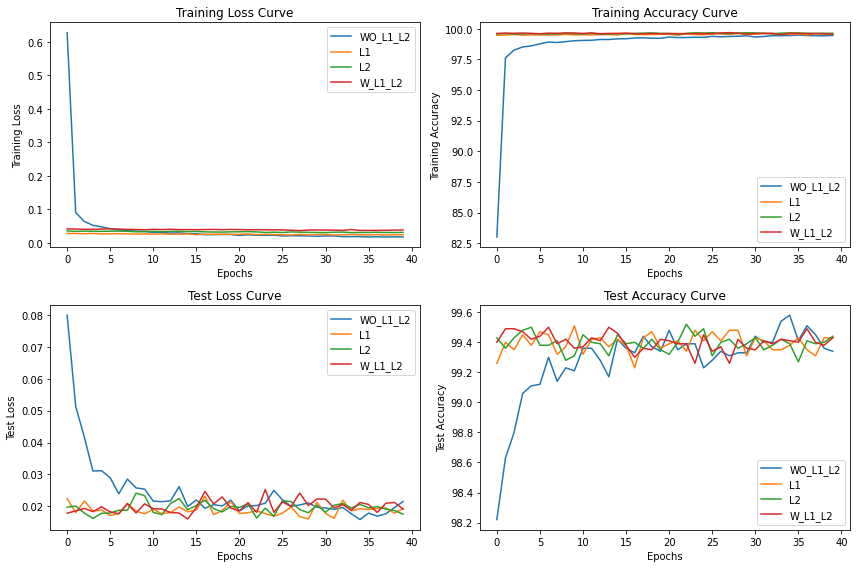

In [ ]:
visualize_graph(filepath, regularizers, train_loss, test_loss, train_accuracy, test_accuracy) 

Visualizing the misclassified images for models with L1 and L2 regularization

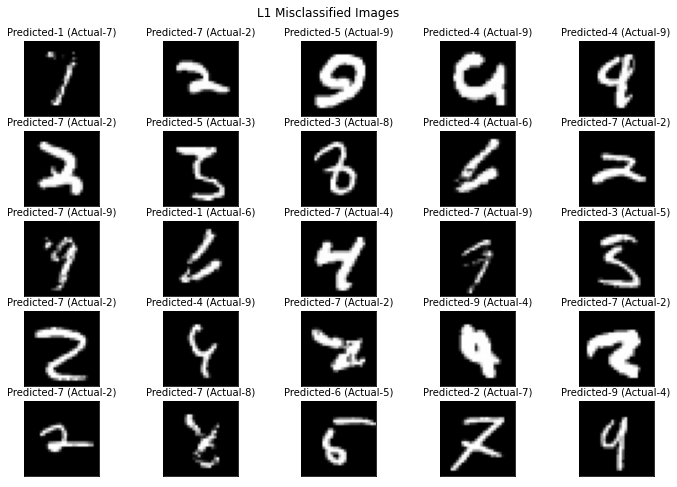

In [ ]:
visualize_misclassified(filepath, 'L1', misclassified_imgs)

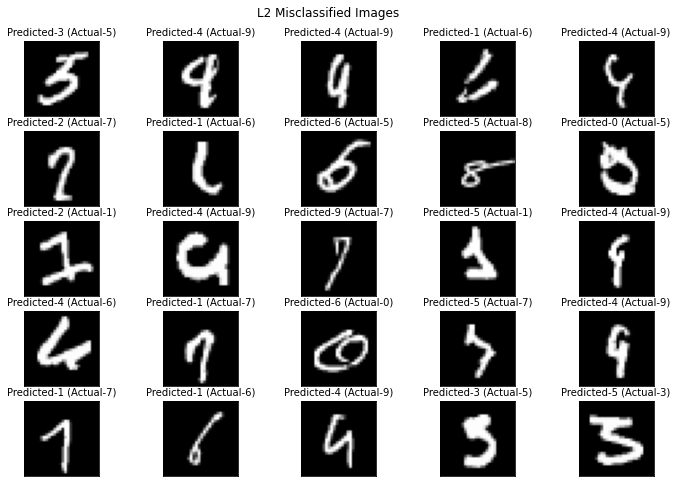

In [ ]:
visualize_misclassified(filepath, 'L2', misclassified_imgs)

## S6 - Solution Quiz:
Explain your observation w.r.t L1 and L2's performance in the regularization of your model.

This model does not require any regularization. With regularization, the gap between training accuracy and test accuracy should reduce. But from the comparison of the differences between training and test accuracy for all the models, we see that the model without L1 or L2 regularization performs much better with a small difference (0.11). By adding L1 or L2 regularization, we see that from the loss and accuracy graphs, loss seems to be fluctuating at the same plateau and accuracy does not increase. This implies that the model is already performing well and L1 or L2 regularization does not seem to have any impact on this model. 

## Quiz 6:
1. Image Normalization and Image Equalization are same things. True or False?
  
  False

2. Image normalization helps
 
 * the model to handle different variations of images
 * train the network to handle image covariate shift

 3. Batch Normalization

  * solves internal covariate shift
  * reduces the need for highly tuned hyperparameters.
  * helps train deeper networks
  * helps train networks faster

4. A layer has 32 channels. It will
 
 * have 32 means and 32 variance

5. Bias

 * gets subtracted out when BN is used

6. If BN is used, which of the following are True?
 
 * larger learning rate can be used
 * kernel values will be smaller
 * gradient flow will not diminish a lot in backprop
 * per epoch would be slightly slower

7. If we use regularization (L1/L2):
 
 * we can solve over-fitting
 * kernel values are going to be close to zero or small

8. If we create our data set in such a way that our images are automatically normalized then would we need BN?

 * Yes, BN has more to do with features than pixel intensities, and image normalization does not guarantee that all features would have normalized values.

9. Later we'd see that we can add as well as concantenate the channels. Which statement is True?

 * BN can be done either before or after adding or concatenating the channels. It doesn't matter!


### That's all Folks!